In [57]:
!pip install pandas
!pip install numpy
!pip install glob
!pip install matplotlib
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pi

In [58]:
import pandas as pd
import numpy as np
import glob
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_squared_error, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression


In [59]:
leagues_to_keep = ['LEC', 'LCK', 'LCS', 'LPL', 'LTA N', 'LTA S', 'LTA', 'PCS', 'FST', 'MSI', 'WLDs', "CBLOLA","NLC", "LCKC", "LPLC", "LDL","LFL", "PRM", "LVP SL", "NACL","UL","CBLOL", "PCS", "VCS", "LCO", "LJL"]
underRegion = ["CBLOL", "PCS", "VCS", "LCO", "LJL"]
Academy = ["CBLOLA","NLC", "LCKC", "LPLC", "LDL","LFL", "PRM", "LVP SL", "NACL","UL",""]
Main_League = ["LEC", "LCK", "LCS", "LPL", "LTA N", "LTA S", "LTA", "PCS", "FST", "MSI", "WLDs"]

In [60]:
penalty_cols = [
    'kills', 'deaths', 'assists',
    'totalgold', 'earnedgold',
    'damagetochampions', 'damageshare',
    'visionscore', 'wardsplaced',
    'minionkills', 'monsterkills'
]

In [61]:
# Find and load all matching data files
training = glob.glob('./Dataset/2023_LoL_esports_match_data_from_OraclesElixir.csv') + \
          glob.glob('./Dataset/2024_LoL_esports_match_data_from_OraclesElixir.csv')
testing = glob.glob('./Dataset/2025_LoL_esports_match_data_from_OraclesElixir.csv')

if not training:
    print("No matching files found. Please upload the files first!")
else:
    dfs = []
    for file in training:
        print(f"Loading {file}...")
        df = pd.read_csv(file)
        is_academy = df['league'].isin(Academy)

        for col in penalty_cols:
          if col in df.columns:
              # Ensure float type to avoid FutureWarning
              df[col] = df[col].astype(float)
              df.loc[is_academy, col] *= 0.7


        print(f"✅ Applied penalty to {is_academy.sum()} rows in {file}")

        dfs.append(df)

    # 👇 Concatenate all DataFrames into one
    full_df = pd.concat(dfs, ignore_index=True)

    # 👇 Now filter to only include specified leagues
    full_df = full_df[full_df['league'].isin(leagues_to_keep)]

    print(f"Total rows loaded after filtering to selected leagues: {len(full_df)}")

if not testing:
    print("No testing file found!")
else:
    print(f"Loading {testing[0]}...")
    test_df = pd.read_csv(testing[0])
    print(f"✅ Loaded testing data with {len(test_df)} rows.")


Loading ./Dataset/2023_LoL_esports_match_data_from_OraclesElixir.csv...
✅ Applied penalty to 40512 rows in ./Dataset/2023_LoL_esports_match_data_from_OraclesElixir.csv
Loading ./Dataset/2024_LoL_esports_match_data_from_OraclesElixir.csv...


/tmp/ipykernel_586898/1149069433.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


✅ Applied penalty to 35124 rows in ./Dataset/2024_LoL_esports_match_data_from_OraclesElixir.csv
Total rows loaded after filtering to selected leagues: 146472
Loading ./Dataset/2025_LoL_esports_match_data_from_OraclesElixir.csv...
✅ Loaded testing data with 44184 rows.


/tmp/ipykernel_586898/1149069433.py:38: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv(testing[0])


In [ ]:
# Assume you already loaded full_df above
df = full_df.copy()
df = df[df['playername'].notna() & df['teamname'].notna() & df['gameid'].notna() & df['date'].notna()]
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# Sort by date
df = df.sort_values(by='date')

# Initialize Elo system
elo_ratings = defaultdict(lambda: 1000)
K_base = 20  # base K

# List of international events
international_leagues = {'MSI', 'FST', 'WLDs'}

# Process games with progress printing
gameids = df['gameid'].unique()
total_games = len(gameids)

for i, gameid in enumerate(gameids, start=1):
    print(f"Processing game {i} of {total_games}: {gameid}")

    game_data = df[df['gameid'] == gameid]

    if game_data['teamname'].nunique() != 2:
        continue

    # Get league + playoff
    league = game_data['league'].iloc[0]
    is_playoff = game_data['playoffs'].iloc[0]

    # Set base K depending on league type
    if league == 'FST':
        K = K_base * 10
    elif league == 'MSI':
        K = K_base * 15
    elif league == 'WLDs':
        K = K_base * 25
    else:
        K = K_base

    # Apply region multipliers
    if league in Academy:
        K *= 0.3

    # Boost K if it's a playoff game
    if is_playoff == 1:
      if league in Main_League:
          K *= 3
      elif league in Academy:
          K *= 1
      elif league in underRegion:
          K *= 2
    teams = game_data.groupby('teamname')
    try:
        team1, team2 = list(teams)
    except ValueError:
        continue

    team1_result = team1[1]['result'].iloc[0]
    team2_result = team2[1]['result'].iloc[0]

    if team1_result == team2_result:
        continue

    if team1_result > team2_result:
        winning_team, losing_team = team1[1], team2[1]
    else:
        winning_team, losing_team = team2[1], team1[1]

    win_elos = [elo_ratings[p] for p in winning_team['playername']]
    lose_elos = [elo_ratings[p] for p in losing_team['playername']]

    for winner in winning_team['playername']:
      for loser in losing_team['playername']:
          winner_elo = elo_ratings[winner]
          loser_elo = elo_ratings[loser]

          expected_win = 1 / (1 + 10 ** ((loser_elo - winner_elo) / 200))
          expected_lose = 1 - expected_win

          # Determine the reduction factor for loser
          # Determine reduction factor for loser
          if is_playoff == 1:
              if league in Academy:
                  reduction_factor = 1  # Academy playoff: full elo loss
              else:
                  reduction_factor = 0.75  # Regular playoff: 75% elo loss
          elif league in ['MSI', 'WLDs', 'FST']:
              reduction_factor = 0.8  # International event: 80% elo loss
          else:
              reduction_factor = 1.0  # Normal game: full elo loss

          # Update winner Elo normally
          elo_ratings[winner] += (K / len(losing_team)) * (1 - expected_win)

          # Update loser Elo with reduction factor
          elo_ratings[loser] += (K / len(winning_team)) * (0 - expected_lose) * reduction_factor



# Save Elo ratings
elo_df = pd.DataFrame(elo_ratings.items(), columns=['playername', 'elo'])
elo_df = elo_df.sort_values(by='elo', ascending=False).reset_index(drop=True)
elo_df.to_csv('./Dataset/player_elos.csv', index=False)

print("Player Elo ratings calculated and saved.")


In [66]:
# --- Only keep rows with players ---
player_df = full_df[full_df['playername'].notna()]

# Columns we care about (added 'league' to track it)
player_stats_cols = [
    'playername', 'position', 'league',
    'kills', 'deaths', 'assists',
    'dpm', 'damageshare', 'wardsplaced', 'wpm', 'visionscore', 'vspm',
    'totalgold', 'earnedgold', 'earned gpm', 'damagetochampions',
    'minionkills', 'monsterkills', 'result'
]

player_df = player_df[player_stats_cols]

# Force numeric on stat columns
for col in player_df.columns:
    if col not in ['playername', 'position', 'league']:
        player_df[col] = pd.to_numeric(player_df[col], errors='coerce')

# Drop rows with missing important data
player_df = player_df.dropna()

# ✅ Average per player (NO league in grouping now)
player_profiles = player_df.groupby(['playername', 'position']).mean(numeric_only=True).reset_index()

# ✅ Calculate win percentage ONLY for Main_League games
Main_League = ["LEC", "LCK", "LCS", "LPL", "LTA N", "LTA S", "LTA", "PCS", "FST", "MSI", "WLDs"]

# Filter to Main_League games
main_league_df = player_df[player_df['league'].isin(Main_League)]

# Group by player & position to get win counts and total counts
win_stats = main_league_df.groupby(['playername', 'position'])['result'].agg(
    total_games='count',
    total_wins='sum'  # assuming 'result' is 1 for win, 0 for loss
).reset_index()

# Compute win %
win_stats['win_percent'] = win_stats['total_wins'] / win_stats['total_games']

# Merge win_percent into player_profiles
player_profiles = player_profiles.merge(win_stats[['playername', 'position', 'win_percent']],
                                        on=['playername', 'position'],
                                        how='left')

# Fill NaN win_percent with 0 (players with no Main_League games)
player_profiles['win_percent'] = player_profiles['win_percent'].fillna(0)

# Save base player profiles
player_profiles.to_csv('./Dataset/top_players.csv', index=False)
print("✅ Base player profiles created and saved as ./Dataset/top_players.csv (with win % now)")

# --- Train Model (no region-based Elo blending) ---
player_profiles = pd.read_csv('./Dataset/top_players.csv')
elo_df = pd.read_csv('./Dataset/player_elos.csv')

# Merge Elo into player profiles
player_profiles = player_profiles.merge(elo_df, on='playername', how='left')
player_profiles = player_profiles.dropna(subset=['elo'])

# One-hot encode position (still here, but not used in scoring)
player_profiles = pd.get_dummies(player_profiles, columns=['position'])

# Build feature set
drop_cols = [col for col in ['playername', 'performance_score', 'result', 'region'] if col in player_profiles.columns]
features = player_profiles.drop(columns=drop_cols)
target = player_profiles['result']

✅ Base player profiles created and saved as ./Dataset/top_players.csv (with win % now)


In [68]:
# Train Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(features, target)

# Get feature importances
importances = model.feature_importances_
importances = importances / importances.sum()

# Map back feature importances
feature_weights = pd.Series(importances, index=features.columns).sort_values(ascending=False)

# Add new performance scores
player_profiles['performance_score'] = features.dot(importances)

# Save full player profiles
player_profiles.to_csv('./Dataset/top_players_with_elo.csv', index=False)

print("\n✅ Model trained. Player profiles with Elo, win %, and performance score saved.")
print("\nFeature Importances:")
print(feature_weights)


✅ Model trained. Player profiles with Elo, win %, and performance score saved.

Feature Importances:
elo                  0.472401
assists              0.161850
deaths               0.114470
earned gpm           0.033911
win_percent          0.024467
kills                0.023470
earnedgold           0.021126
monsterkills         0.016492
minionkills          0.015712
damagetochampions    0.015577
totalgold            0.015293
visionscore          0.014940
vspm                 0.014455
damageshare          0.014442
dpm                  0.013094
wardsplaced          0.012124
wpm                  0.010495
position_top         0.003280
position_mid         0.001120
position_bot         0.000934
position_sup         0.000177
position_jng         0.000168
dtype: float64


In [71]:
# --- Load Player Profiles and Train Model ---

# Load player stats
player_profiles = pd.read_csv('./Dataset/top_players_with_elo.csv')

# Define feature columns
feature_columns = player_profiles.columns.difference(['playername', 'performance_score', 'result', 'region'])

# Build player lookup
player_stat_lookup = player_profiles.set_index('playername')[feature_columns]

# Prepare training data
target = player_profiles['result']
features = player_profiles[feature_columns]

# Train model
model = RandomForestRegressor(random_state=42)
model.fit(features, target)

# Define default player stats if missing
default_player = pd.Series(0, index=feature_columns)
if 'elo' in default_player.index:
    default_player['elo'] = 800



In [72]:
# --- Load 2025 Testing Data ---
test_file = './Dataset/2025_LoL_esports_match_data_from_OraclesElixir.csv'
test_df = pd.read_csv(test_file)

# Columns we care about (same as before)
player_stats_cols = [
    'playername', 'position', 'league',
    'kills', 'deaths', 'assists',
    'dpm', 'damageshare', 'wardsplaced', 'wpm', 'visionscore', 'vspm',
    'totalgold', 'earnedgold', 'earned gpm', 'damagetochampions',
    'minionkills', 'monsterkills', 'result'
]

# Keep only needed columns
test_df = test_df[player_stats_cols]

# Drop rows without playername or missing key data
test_df = test_df.dropna(subset=['playername'])

# Force numeric on stat columns
for col in test_df.columns:
    if col not in ['playername', 'position', 'league']:
        test_df[col] = pd.to_numeric(test_df[col], errors='coerce')

# Fill missing numeric data with 0 (you can also choose to dropna if preferred)
test_df = test_df.fillna(0)

# --- Add Elo to Testing Data ---
elo_df = pd.read_csv('./Dataset/player_elos.csv')
test_df = test_df.merge(elo_df, on='playername', how='left')

# Fill missing Elo with default value (800)
test_df['elo'] = test_df['elo'].fillna(800)

# --- Add win_percent to Testing Data ---
# Filter to Main_League for win %
Main_League = ["LEC", "LCK", "LCS", "LPL", "LTA N", "LTA S", "LTA", "PCS", "FST", "MSI", "WLDs"]
main_league_df = test_df[test_df['league'].isin(Main_League)]

# Group by player & position to get win counts and total counts
win_stats = main_league_df.groupby(['playername', 'position'])['result'].agg(
    total_games='count',
    total_wins='sum'
).reset_index()
win_stats['win_percent'] = win_stats['total_wins'] / win_stats['total_games']

# Merge win_percent into test_df
test_df = test_df.merge(win_stats[['playername', 'position', 'win_percent']],
                        on=['playername', 'position'],
                        how='left')
test_df['win_percent'] = test_df['win_percent'].fillna(0)

# --- One-hot encode position (match training format) ---
test_df = pd.get_dummies(test_df, columns=['position'])

# --- Align test features with training features ---
# Ensure test set has same feature columns as training (add missing ones as 0)
for col in feature_columns:
    if col not in test_df.columns:
        test_df[col] = 0

# Reorder columns to match the model
test_features = test_df[feature_columns]

# --- Predict using the trained model ---
test_df['predicted_result'] = model.predict(test_features)

# --- Save to CSV ---
test_df.to_csv('./Dataset/2025_test_with_predictions.csv', index=False)

print("\n✅ Predictions complete! Saved to ./Dataset/2025_test_with_predictions.csv")

# --- Compare Predictions vs Actual ---
from sklearn.metrics import mean_squared_error, r2_score

actual = test_df['result']
predicted = test_df['predicted_result']

mse = mean_squared_error(actual, predicted)
r2 = r2_score(actual, predicted)

print(f"\n📊 Model Evaluation on 2025 Testing Data:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")


/tmp/ipykernel_586898/1977020471.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv(test_file)



✅ Predictions complete! Saved to ./Dataset/2025_test_with_predictions.csv

📊 Model Evaluation on 2025 Testing Data:
Mean Squared Error (MSE): 0.1404
R^2 Score: 0.4384


In [73]:
# --- Train XGBoost model ---
xgb_model = xgb.XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=6)
xgb_model.fit(features, target)

# --- Predict using XGBoost ---
test_df['predicted_result_xgb'] = xgb_model.predict(test_features)

# --- Clip predictions to 0-1 range (for probabilities or win rates) ---
test_df['predicted_result_xgb'] = test_df['predicted_result_xgb'].clip(0, 1)

# --- Evaluate performance ---
mse_xgb = mean_squared_error(test_df['result'], test_df['predicted_result_xgb'])
r2_xgb = r2_score(test_df['result'], test_df['predicted_result_xgb'])

print(f"\n📊 XGBoost Evaluation on 2025 Testing Data:")
print(f"Mean Squared Error (MSE): {mse_xgb:.4f}")
print(f"R^2 Score: {r2_xgb:.4f}")

# --- Save to CSV ---
test_df.to_csv('./Dataset/2025_test_with_xgb_predictions.csv', index=False)
print("\n✅ XGBoost predictions saved to ./Dataset/2025_test_with_xgb_predictions.csv")



📊 XGBoost Evaluation on 2025 Testing Data:
Mean Squared Error (MSE): 0.1333
R^2 Score: 0.4668

✅ XGBoost predictions saved to ./Dataset/2025_test_with_xgb_predictions.csv


In [74]:
# --- Get feature importances ---
feature_importances = xgb_model.feature_importances_

# --- Map to feature names ---
importance_df = pd.DataFrame({
    'feature': features.columns,
    'importance': feature_importances
})

# --- Sort by importance ---
importance_df = importance_df.sort_values(by='importance', ascending=False)

# --- Print nicely ---
print("\n📊 XGBoost Feature Importances:")
for idx, row in importance_df.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")



📊 XGBoost Feature Importances:
elo: 0.3604
deaths: 0.0914
assists: 0.0771
win_percent: 0.0463
position_top: 0.0452
totalgold: 0.0440
earned gpm: 0.0393
earnedgold: 0.0350
kills: 0.0338
position_sup: 0.0310
visionscore: 0.0230
minionkills: 0.0225
damagetochampions: 0.0216
wardsplaced: 0.0213
position_bot: 0.0195
monsterkills: 0.0173
damageshare: 0.0158
vspm: 0.0148
wpm: 0.0145
dpm: 0.0140
position_mid: 0.0119
position_jng: 0.0000


In [75]:
# --- Train Gradient Boosting model ---
gb_model = GradientBoostingRegressor(
    random_state=42,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    max_features=0.8
)

gb_model.fit(features, target)

# --- Predict using Gradient Boosting ---
test_df['predicted_result_gb'] = gb_model.predict(test_features)

# --- Clip predictions to 0-1 range (for probabilities or win rates) ---
test_df['predicted_result_gb'] = test_df['predicted_result_gb'].clip(0, 1)

# --- Evaluate performance ---
mse_gb = mean_squared_error(test_df['result'], test_df['predicted_result_gb'])
r2_gb = r2_score(test_df['result'], test_df['predicted_result_gb'])

print(f"\n📊 Gradient Boosting Evaluation on 2025 Testing Data:")
print(f"Mean Squared Error (MSE): {mse_gb:.4f}")
print(f"R^2 Score: {r2_gb:.4f}")

# --- Save to CSV ---
test_df.to_csv('./Dataset/2025_test_with_gb_predictions.csv', index=False)
print("\n✅ Gradient Boosting predictions saved to ./Dataset/2025_test_with_gb_predictions.csv")



📊 Gradient Boosting Evaluation on 2025 Testing Data:
Mean Squared Error (MSE): 0.1284
R^2 Score: 0.4866

✅ Gradient Boosting predictions saved to ./Dataset/2025_test_with_gb_predictions.csv


In [76]:
# --- Get feature importances ---
feature_importances = gb_model.feature_importances_

# --- Map to feature names ---
importance_df = pd.DataFrame({
    'feature': features.columns,
    'importance': feature_importances
})

# --- Sort by importance ---
importance_df = importance_df.sort_values(by='importance', ascending=False)

# --- Print nicely ---
print("\n📊 Gradient Boosting Feature Importances:")
for idx, row in importance_df.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")



📊 Gradient Boosting Feature Importances:
elo: 0.4112
assists: 0.1828
deaths: 0.1199
earned gpm: 0.0455
kills: 0.0315
win_percent: 0.0239
damagetochampions: 0.0199
earnedgold: 0.0195
damageshare: 0.0187
monsterkills: 0.0184
minionkills: 0.0181
totalgold: 0.0154
vspm: 0.0148
dpm: 0.0137
visionscore: 0.0129
wardsplaced: 0.0129
wpm: 0.0107
position_top: 0.0076
position_bot: 0.0014
position_mid: 0.0006
position_sup: 0.0002
position_jng: 0.0002


In [77]:
# --- Convert target to binary (if needed) ---
target_binary = (target >= 0.5).astype(int)
actual_binary = (test_df['result'] >= 0.5).astype(int)

# --- Train Logistic Regression ---
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(features, target_binary)

# --- Predict probabilities and labels ---
logreg_proba = logreg_model.predict_proba(test_features)[:, 1]  # probability of class 1
logreg_preds = logreg_model.predict(test_features)              # predicted class (0 or 1)

# --- Add predictions to test_df ---
test_df['predicted_result_logreg_proba'] = logreg_proba
test_df['predicted_result_logreg'] = logreg_preds

# --- Evaluate performance ---
accuracy = accuracy_score(actual_binary, logreg_preds)
mse_logreg = mean_squared_error(actual_binary, logreg_proba)
try:
    auc = roc_auc_score(actual_binary, logreg_proba)
except:
    auc = None

print(f"\n📊 Logistic Regression Evaluation on 2025 Testing Data:")
print(f"Accuracy: {accuracy:.4f}")
print(f"MSE (on probability scores): {mse_logreg:.4f}")
if auc is not None:
    print(f"AUC Score: {auc:.4f}")

# --- Save to CSV ---
test_df.to_csv('./Dataset/2025_test_with_logreg_predictions.csv', index=False)
print("\n✅ Logistic Regression predictions saved to ./Dataset/2025_test_with_logreg_predictions.csv")


/usr/local/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



📊 Logistic Regression Evaluation on 2025 Testing Data:
Accuracy: 0.8659
MSE (on probability scores): 0.1082
AUC Score: 0.9304

✅ Logistic Regression predictions saved to ./Dataset/2025_test_with_logreg_predictions.csv


In [78]:
# --- Get feature coefficients ---
coefficients = logreg_model.coef_[0]  # shape (n_features, )

# --- Map to feature names ---
coef_df = pd.DataFrame({
    'feature': features.columns,
    'coefficient': coefficients
})

# --- Calculate absolute value for sorting by strength ---
coef_df['abs_coefficient'] = coef_df['coefficient'].abs()

# --- Sort by absolute strength ---
coef_df = coef_df.sort_values(by='abs_coefficient', ascending=False)

# --- Print nicely ---
print("\n📊 Logistic Regression Feature Coefficients:")
for idx, row in coef_df.iterrows():
    sign = '+' if row['coefficient'] >= 0 else '-'
    print(f"{row['feature']}: {sign}{abs(row['coefficient']):.4f}")



📊 Logistic Regression Feature Coefficients:
assists: +0.7927
deaths: -0.6240
position_bot: -0.2209
position_top: +0.1646
kills: -0.1257
position_mid: +0.0959
vspm: -0.0898
earned gpm: -0.0746
position_sup: -0.0723
wardsplaced: -0.0525
monsterkills: -0.0500
win_percent: +0.0461
minionkills: -0.0442
wpm: -0.0441
dpm: +0.0282
damageshare: -0.0111
visionscore: +0.0108
earnedgold: +0.0100
elo: +0.0044
totalgold: -0.0041
position_jng: -0.0021
damagetochampions: -0.0014


In [80]:
def get_top_teams(test_df, team_dict):
    team_win_probs = {}

    for team, players in team_dict.items():
        team_players_df = test_df[test_df['playername'].isin(players)]
        if team_players_df.empty:
            print(f"⚠️ Warning: No matching players found for {team}")
            continue

        avg_win_prob = team_players_df['predicted_result_logreg_proba'].mean()
        team_win_probs[team] = avg_win_prob

    sorted_teams = sorted(team_win_probs.items(), key=lambda x: x[1], reverse=True)

    print("\n🏆 Team Win Probability Leaderboard:")
    for rank, (team, prob) in enumerate(sorted_teams, 1):
        print(f"{rank}. {team}: {prob:.4f}")

    top_team, top_prob = sorted_teams[0]
    print(f"\n🔥 Team with highest predicted win probability: {top_team} ({top_prob:.4f})")

    return team_win_probs


In [81]:
def simulate_standings(team_probs, n_simulations=1000):
    teams = list(team_probs.keys())
    n_teams = len(teams)
    cumulative_wins = {team: 0 for team in teams}

    for _ in range(n_simulations):
        sim_wins = {team: 0 for team in teams}
        for i in range(n_teams):
            for j in range(i + 1, n_teams):
                team_a = teams[i]
                team_b = teams[j]
                prob_a = team_probs[team_a]
                prob_b = team_probs[team_b]
                prob_a_wins = prob_a / (prob_a + prob_b)
                winner = np.random.choice([team_a, team_b], p=[prob_a_wins, 1 - prob_a_wins])
                sim_wins[winner] += 1

        for team in teams:
            cumulative_wins[team] += sim_wins[team]

    avg_wins = {team: cumulative_wins[team] / n_simulations for team in teams}

    standings_df = pd.DataFrame({
        'team': teams,
        'score': [avg_wins[team] for team in teams]
    }).sort_values(by='score', ascending=False).reset_index(drop=True)
    standings_df['rank'] = standings_df.index + 1

    print("\n🏆 Predicted Team Standings (1000 simulations):")
    for idx, row in standings_df.iterrows():
        print(f"{row['rank']}. {row['team']}")

    return standings_df  # ✅ RETURN the DataFrame


In [82]:
def plot_team_probabilities(team_probs, title='Team Leaderboard', xlabel='Predicted Value', color='skyblue'):
    # Sort teams by probability (highest first)
    sorted_items = sorted(team_probs.items(), key=lambda x: x[1], reverse=True)

    # Unzip into two lists
    teams, probs = zip(*sorted_items)

    # Convert np.float64 to regular float
    probs = [float(p) for p in probs]

    # Plot
    plt.figure(figsize=(8, 6))
    plt.barh(teams, probs, color=color)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.gca().invert_yaxis()  # Highest on top
    plt.tight_layout()
    plt.show()



🏆 Team Win Probability Leaderboard:
1. Fnatic: 0.6161
2. G2 Esports: 0.5784
3. Karmine Corp: 0.5045
4. Movistar KOI: 0.4981
5. Team BDS: 0.4320
6. Team Vitality: 0.4004
7. GIANTX: 0.3736
8. SK Gaming: 0.3702
9. Team Heretics: 0.2842
10. Rogue: 0.2737

🔥 Team with highest predicted win probability: Fnatic (0.6161)

🏆 Predicted Team Standings (1000 simulations):
1. Fnatic
2. G2 Esports
3. Karmine Corp
4. Movistar KOI
5. Team BDS
6. Team Vitality
7. GIANTX
8. SK Gaming
9. Team Heretics
10. Rogue


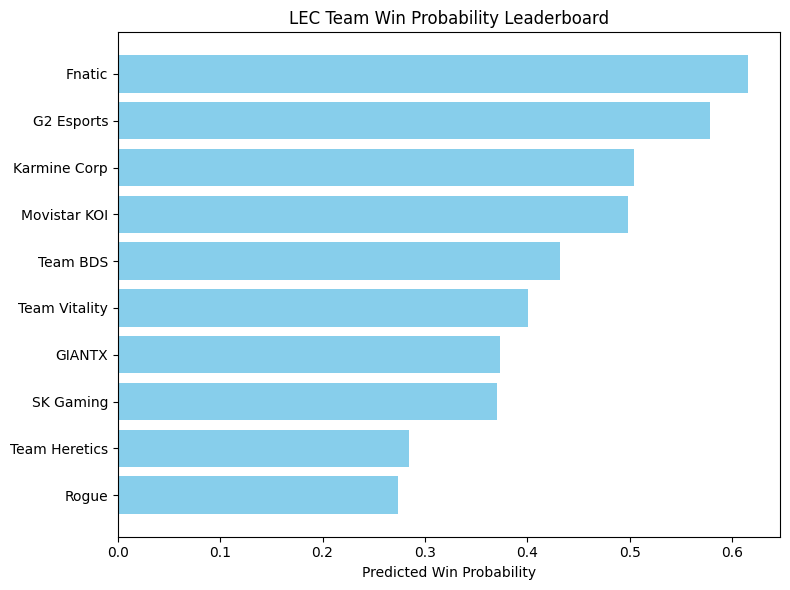

['Fnatic', 'G2 Esports', 'Karmine Corp', 'Movistar KOI', 'Team BDS', 'Team Vitality', 'GIANTX', 'SK Gaming', 'Team Heretics', 'Rogue']


In [83]:
LEC = {
    "Fnatic": ["Oscarinin", "Razork", "Humanoid", "Upset", "Mikyx"],
    "G2 Esports": ["BrokenBlade", "SkewMond", "Caps", "Hans Sama", "Labrov"],
    "GIANTX": ["Lot", "ISMA", "Jackies", "Noah", "Jun"],
    "Karmine Corp": ["Canna", "Yike", "Vladi", "Caliste", "Targamas"],
    "Movistar KOI": ["Myrwn", "Elyoya", "Jojopyun", "Supa", "Alvaro"],
    "Rogue": ["Adam", "Malrang", "Larssen", "Patrik", "Execute"],
    "SK Gaming": ["JNX", "Boukada", "RKR", "Keduii", "Loopy"],
    "Team BDS": ["Irrelevant", "113", "nuc", "Ice", "Parus"],
    "Team Heretics": ["Carlsen", "Sheo", "Kamiloo", "Flakked", "Stend"],
    "Team Vitality": ["Naak Nako", "Lyncas", "Czajek", "Carzzy", "Nisqy"]
}

team_probs = get_top_teams(test_df, LEC)
standings_df = simulate_standings(team_probs, n_simulations=1000)
predicted_standings = standings_df['team'].tolist()


plot_team_probabilities(
    team_probs,
    title='LEC Team Win Probability Leaderboard',
    xlabel='Predicted Win Probability',
    color='skyblue'
)
predicted_standings = standings_df['team'].tolist()
print(predicted_standings)

In [84]:
actual_standings = [
    'Fnatic', 'Karmine Corp', 'G2 Esports', 'Movistar KOI', 'Team Vitality',
    'GIANTX', 'Team BDS', 'Team Heretics','SK Gaming', 'Rogue'
]
actual_ranks = {team: rank for rank, team in enumerate(actual_standings, start=1)}
predicted_ranks = {team: rank for rank, team in enumerate(predicted_standings, start=1)}
mae = np.mean([abs(actual_ranks[team] - predicted_ranks[team]) for team in actual_standings])
print(f'Mean Absolute Error (MAE): {mae:.2f}')


Mean Absolute Error (MAE): 0.80



🏆 Team Win Probability Leaderboard:
1. FlyQuest: 0.7107
2. Cloud9: 0.6686
3. 100 Thieves: 0.6065
4. Team Liquid: 0.5558
5. LYON: 0.3379
6. Shopify Rebellion: 0.2815
7. Dignitas: 0.2342
8. Disguised: 0.1647

🔥 Team with highest predicted win probability: FlyQuest (0.7107)

🏆 Predicted Team Standings (1000 simulations):
1. FlyQuest
2. Cloud9
3. 100 Thieves
4. Team Liquid
5. LYON
6. Shopify Rebellion
7. Dignitas
8. Disguised


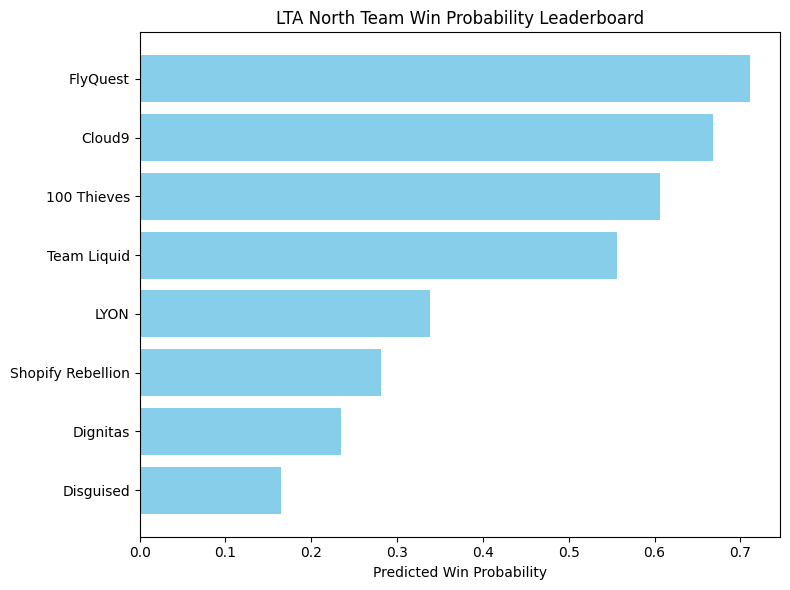

['FlyQuest', 'Cloud9', '100 Thieves', 'Team Liquid', 'LYON', 'Shopify Rebellion', 'Dignitas', 'Disguised']


In [85]:
LTA_N= {
        "Cloud9": ["Thanatos", "Blaber", "Loki", "Zven", "Vulcan"],
        "Dignitas": ["Srtty", "Sheiden", "Keine", "Tomo", "Isles"],
        "FlyQuest": ["Bwipo", "Inspired", "Quad", "Massu", "Busio"],
        "LYON": ["Licorice", "Oddielan", "Saint", "Hena", "Lyonz"],
        "Shopify Rebellion": ["Fudge", "Contractz", "Palafox", "Bvoy", "Zeyzal"],
        "Team Liquid": ["Impact", "UmTi", "APA", "Yeon", "CoreJJ"],
        "100 Thieves": ["Sniper", "River", "Quid", "FBI", "Eyla"],
        "Disguised": ["Castle", "eXyu", "Abbedagge", "ScaryJerry", "huhi"]
    }
team_probs = get_top_teams(test_df, LTA_N)
standings_df = simulate_standings(team_probs, n_simulations=1000)
predicted_standings = standings_df['team'].tolist()

plot_team_probabilities(
    team_probs,
    title='LTA North Team Win Probability Leaderboard',
    xlabel='Predicted Win Probability',
    color='skyblue'
)
print(predicted_standings)

In [86]:
actual = [
    '100 Thieves', 'Cloud9', 'FlyQuest', 'Team Liquid',
    'Dignitas', 'Shopify Rebellion', 'LYON', 'Disguised'
]

actual_ranks = {team: rank for rank, team in enumerate(actual, start=1)}
predicted_ranks = {team: rank for rank, team in enumerate(predicted_standings, start=1)}

mae = np.mean([abs(actual_ranks[team] - predicted_ranks[team]) for team in actual])
print(f'Mean Absolute Error (MAE): {mae:.2f}')


Mean Absolute Error (MAE): 1.00



🏆 Team Win Probability Leaderboard:
1. FURIA: 0.5880
2. paiN Gaming: 0.5851
3. Vivo Keyd Stars: 0.5085
4. LOUD: 0.4139
5. RED Canids: 0.4051
6. Leviatan: 0.3360
7. Isurus Estral: 0.3036
8. Fluxo W7M: 0.2131

🔥 Team with highest predicted win probability: FURIA (0.5880)

🏆 Predicted Team Standings (1000 simulations):
1. FURIA
2. paiN Gaming
3. Vivo Keyd Stars
4. LOUD
5. RED Canids
6. Leviatan
7. Isurus Estral
8. Fluxo W7M


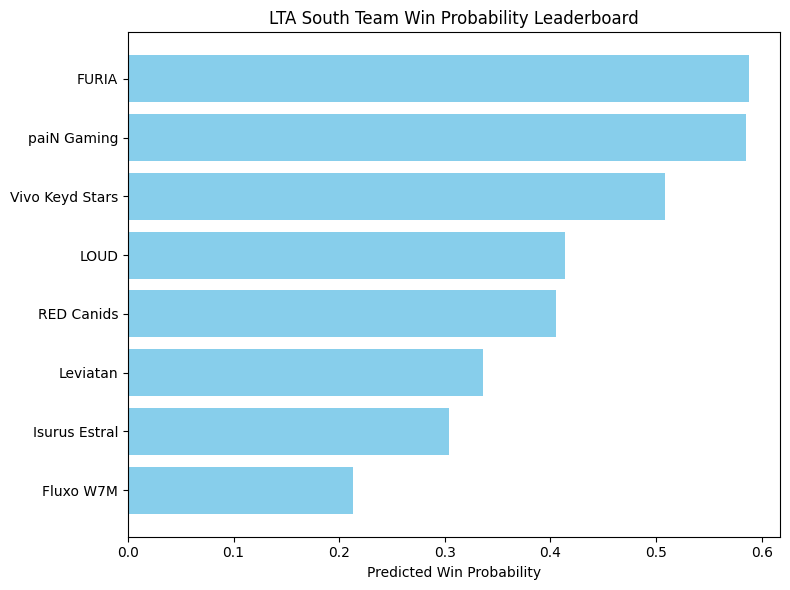

['FURIA', 'paiN Gaming', 'Vivo Keyd Stars', 'LOUD', 'RED Canids', 'Leviatan', 'Isurus Estral', 'Fluxo W7M']


In [87]:
LTA_S={
        "paiN Gaming": ["TitaN", "Roamer", "CarioK", "Kuri", "Wizer"],
        "Isurus Estral":["Summit","Ackerman", "Josedeodo", "Mireu", "Snaker"],
        "Vivo Keyd Stars":["Boal", "Trymbi", "Disamis", "Morttheus", "Kisee"],
        "Leviatan": ["Zothve", "SCARY", "ceo", "cody","ProDelta"],
        "FURIA":["JoJo", "Tutsz", "Ayu", "Tatu","Guigo"],
        "LOUD":["Robo", "tinowns", "Route", "Shini", "RedBert"],
        "RED Canids":["fNb","DOOM", "Mago","Brance", "frosty" ],
        "Fluxo W7M":["Hidan", "Ganks", "Fuuu", "Marvin", "Guigs"]
        }
team_probs = get_top_teams(test_df, LTA_S)
standings_df =simulate_standings(team_probs, n_simulations=1000)
predicted_standings = standings_df['team'].tolist()

plot_team_probabilities(
    team_probs,
    title='LTA South Team Win Probability Leaderboard',
    xlabel='Predicted Win Probability',
    color='skyblue'
)
print(predicted_standings)

In [88]:
actual = ['Isurus Estral', 'Leviatan', 'paiN Gaming', 'LOUD',
          'RED Canids', 'FURIA','Fluxo W7M',  'Vivo Keyd Stars'
]
actual = {team: rank for rank, team in enumerate(actual, start=1)}
predicted_ranks = {team: rank for rank, team in enumerate(predicted_standings, start=1)}
mae = np.mean([abs(actual[team] - predicted_ranks[team]) for team in actual])
print(f'Mean Absolute Error (MAE): {mae:.2f}')

Mean Absolute Error (MAE): 2.75



🏆 Team Win Probability Leaderboard:
1. Hanwha Life: 0.7652
2. T1: 0.7208
3. BNK FEARX: 0.3689
4. OK BRION: 0.3596
5. DN Freecs: 0.2253

🔥 Team with highest predicted win probability: Hanwha Life (0.7652)

🏆 Predicted Team Standings (1000 simulations):
1. Hanwha Life
2. T1
3. BNK FEARX
4. OK BRION
5. DN Freecs


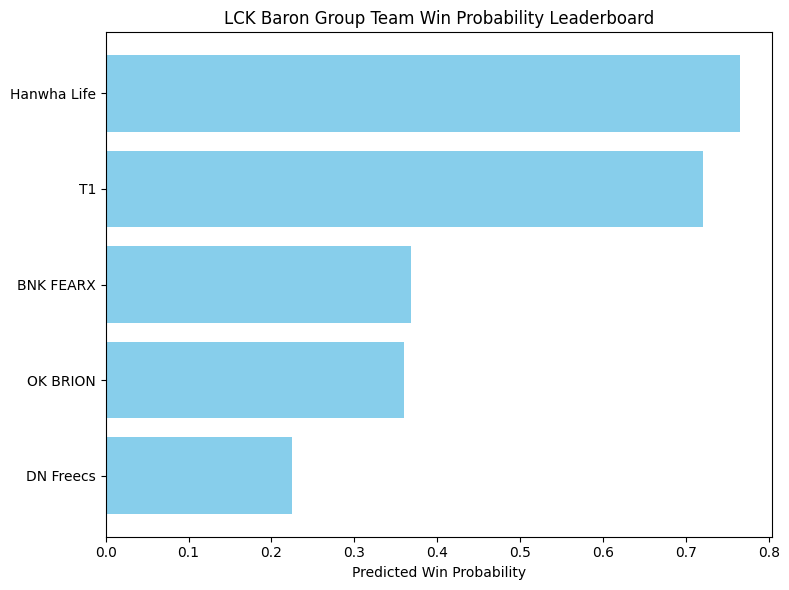

In [89]:
Baron = {"T1": ["Doran", "Oner", "Faker", "Gumayusi", "Keria"],
         "Hanwha Life": ["Zeus", "Peanut", "Zeka", "Viper", "Delight"],
         "OK BRION": ["Morgan", "Ellim", "HamBak", "Clozer", "Bull"],
         "DN Freecs": ["DuDu", "Pyosik", "BuLLDoG", "Berserker", "Life"],
         "BNK FEARX": ["Clear", "Raptor", "VicLa", "Diable", "Kellin"]
         }
team_probs = get_top_teams(test_df, Baron)
standings_df =simulate_standings(team_probs, n_simulations=1000)
predicted_standings = standings_df['team'].tolist()

plot_team_probabilities(
    team_probs,
    title='LCK Baron Group Team Win Probability Leaderboard',
    xlabel='Predicted Win Probability',
    color='skyblue'
)

In [90]:
actual = ['T1', 'Hanwha Life', 'OK BRION', 'DN Freecs', 'BNK FEARX'
]
actual = {team: rank for rank, team in enumerate(actual, start=1)}
predicted_ranks = {team: rank for rank, team in enumerate(predicted_standings, start=1)}
mae = np.mean([abs(actual[team] - predicted_ranks[team]) for team in actual])
print(f'Mean Absolute Error (MAE): {mae:.2f}')

Mean Absolute Error (MAE): 1.20



🏆 Team Win Probability Leaderboard:
1. Gen.G: 0.7023
2. Dplus KIA: 0.5853
3. NS RedForce: 0.5324
4. KT Rolster: 0.5029
5. DRX: 0.3001

🔥 Team with highest predicted win probability: Gen.G (0.7023)

🏆 Predicted Team Standings (1000 simulations):
1. Gen.G
2. Dplus KIA
3. NS RedForce
4. KT Rolster
5. DRX


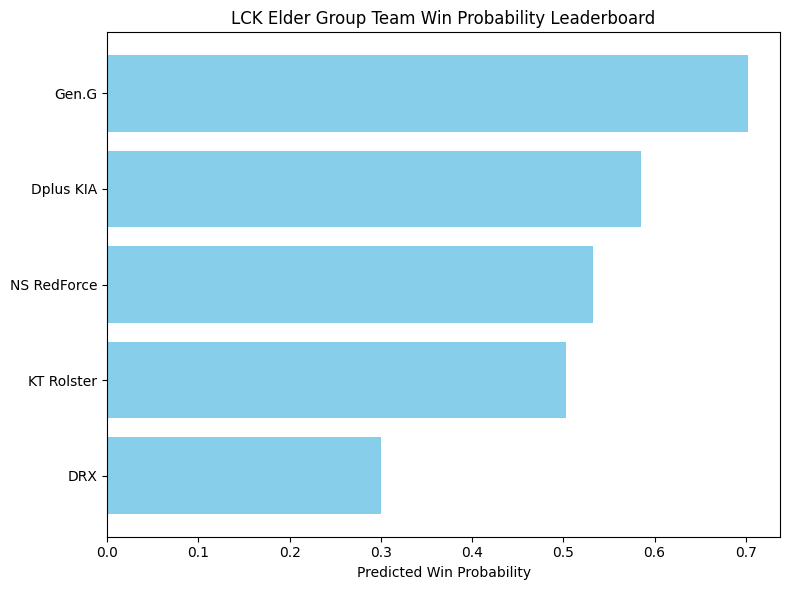

In [91]:
Elder = {
    "Dplus KIA": ["Siwoo", "Lucid", "ShowMaker", "Aiming", "BeryL"],
    "DRX": ["Rich", "Sponge", "Ucal", "Teddy", "Andil"],
    "Gen.G": ["Kiin", "Canyon", "Chovy", "Ruler", "Duro"],
    "KT Rolster": ["PerfecT", "Casting", "Cuzz", "deokdam", "Paduck"],
    "NS RedForce": ["Kingen", "GIDEON", "Calix", "Jiwoo", "Lehends"]
}
team_probs = get_top_teams(test_df, Elder)
standings_df =simulate_standings(team_probs, n_simulations=1000)
predicted_standings = standings_df['team'].tolist()

plot_team_probabilities(
    team_probs,
    title='LCK Elder Group Team Win Probability Leaderboard',
    xlabel='Predicted Win Probability',
    color='skyblue'
)

In [92]:
actual = ['Dplus KIA', 'Gen.G', "KT Rolster", "DRX", "NS RedForce"]
actual = {team: rank for rank, team in enumerate(actual, start=1)}
predicted_ranks = {team: rank for rank, team in enumerate(predicted_standings, start=1)}
mae = np.mean([abs(actual[team] - predicted_ranks[team]) for team in actual])
print(f'Mean Absolute Error (MAE): {mae:.2f}')

Mean Absolute Error (MAE): 1.20



🏆 Team Win Probability Leaderboard:
1. Anyone's Legend: 0.6607
2. Top Esports: 0.6166
3. LGD Gaming: 0.4858
4. Team WE: 0.3530

🔥 Team with highest predicted win probability: Anyone's Legend (0.6607)

🏆 Predicted Team Standings (1000 simulations):
1. Anyone's Legend
2. Top Esports
3. LGD Gaming
4. Team WE


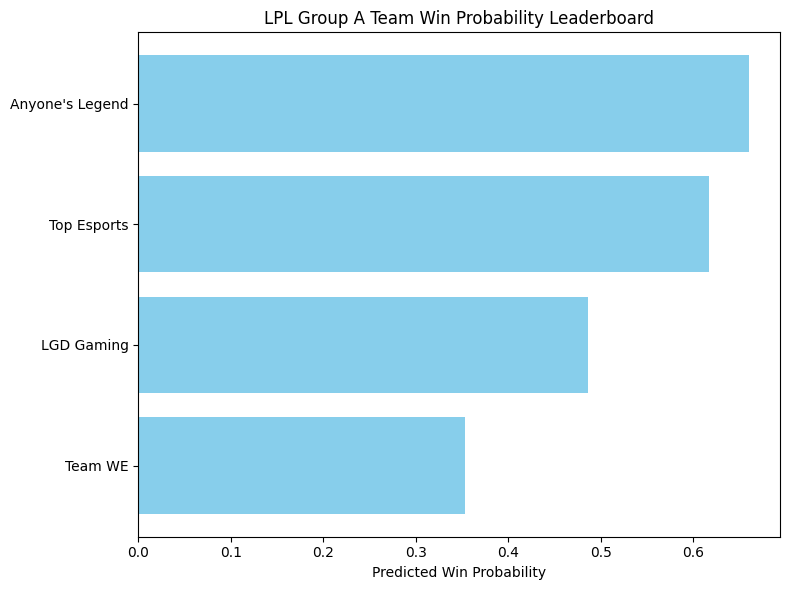

In [93]:
LPL_Group_A = {
    "Anyone's Legend": ["Flandre", "Tarzan", "Shanks", "Hope", "Kael"],
    "Top Esports": ["369", "Kanavi", "Creme", "JackeyLove", "Crisp"],
    "LGD Gaming": ["sasi", "Climber", "xqw", "Shaoye", "Ycx"],
    "Team WE": ["Cube", "Monki", "Karis", "Taeyoon", "Vampire"]
}
team_probs = get_top_teams(test_df, LPL_Group_A)
standings_df =simulate_standings(team_probs, n_simulations=1000)
predicted_standings = standings_df['team'].tolist()

plot_team_probabilities(
    team_probs,
    title='LPL Group A Team Win Probability Leaderboard',
    xlabel='Predicted Win Probability',
    color='skyblue'
)

In [94]:
actual = ["Anyone's Legend", 'Top Esports', "LGD Gaming", "Team WE"]
actual = {team: rank for rank, team in enumerate(actual, start=1)}
predicted_ranks = {team: rank for rank, team in enumerate(predicted_standings, start=1)}
mae = np.mean([abs(actual[team] - predicted_ranks[team]) for team in actual])
print(f'Mean Absolute Error (MAE): {mae:.2f}')

Mean Absolute Error (MAE): 0.00



🏆 Team Win Probability Leaderboard:
1. Weibo Gaming: 0.6650
2. JD Gaming: 0.6510
3. Ultra Prime: 0.4230
4. Oh My God: 0.2907

🔥 Team with highest predicted win probability: Weibo Gaming (0.6650)

🏆 Predicted Team Standings (1000 simulations):
1. Weibo Gaming
2. JD Gaming
3. Ultra Prime
4. Oh My God


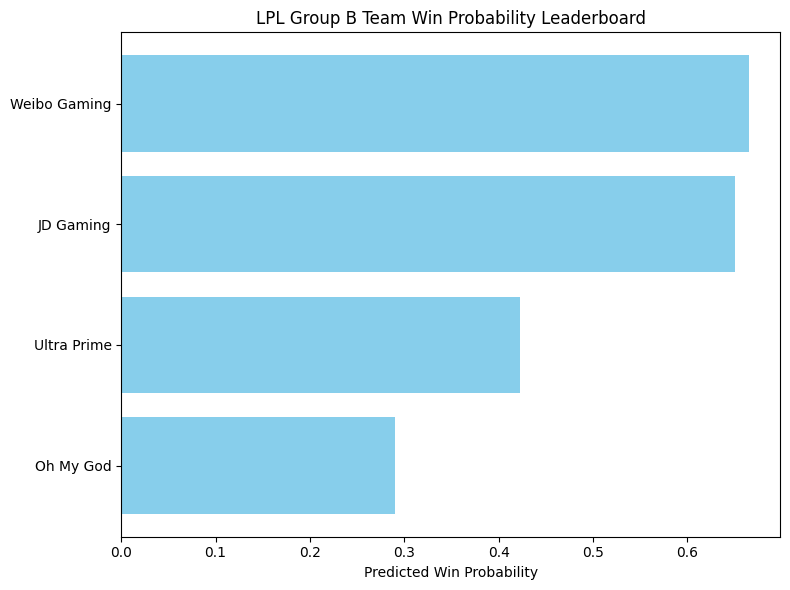

In [95]:
LPL_Group_B={
    "JD Gaming": ["Ale", "Xun", "Scout", "Peyz", "MISSING"],
    "Weibo Gaming": ["Breathe", "Tian", "Xiaohu", "Light", "Hang"],
    "Oh My God": ["Hery", "Heng", "charlotte", "Starry", "Moham"],
    "Ultra Prime": ["1Jiang", "Junhao", "Saber", "Wako", "Xiaoxia"]
}
team_probs = get_top_teams(test_df, LPL_Group_B)
standings_df =simulate_standings(team_probs, n_simulations=1000)
predicted_standings = standings_df['team'].tolist()

plot_team_probabilities(
    team_probs,
    title='LPL Group B Team Win Probability Leaderboard',
    xlabel='Predicted Win Probability',
    color='skyblue'
)

In [96]:
actual = ["JD Gaming", 'Weibo Gaming', "Oh My God", "Ultra Prime"]
actual = {team: rank for rank, team in enumerate(actual, start=1)}
predicted_ranks = {team: rank for rank, team in enumerate(predicted_standings, start=1)}
mae = np.mean([abs(actual[team] - predicted_ranks[team]) for team in actual])
print(f'Mean Absolute Error (MAE): {mae:.2f}')

Mean Absolute Error (MAE): 1.00



🏆 Team Win Probability Leaderboard:
1. Bilibili Gaming: 0.7726
2. ThunderTalk Gaming: 0.4075
3. Edward Gaming: 0.3998
4. LNG Esports: 0.3124

🔥 Team with highest predicted win probability: Bilibili Gaming (0.7726)

🏆 Predicted Team Standings (1000 simulations):
1. Bilibili Gaming
2. Edward Gaming
3. ThunderTalk Gaming
4. LNG Esports


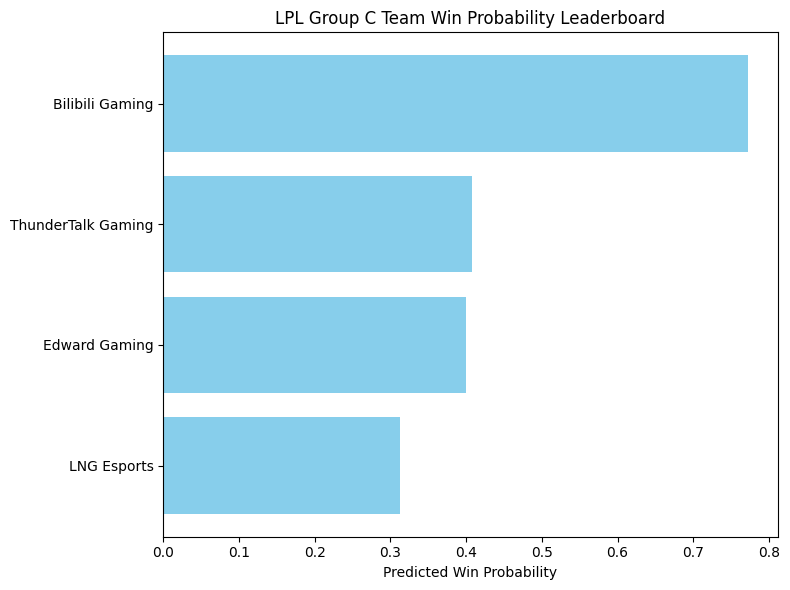

In [97]:
LPL_Group_C={
    "ThunderTalk Gaming": ["HOYA", "Beichuan", "SeTab", "1xn", "Feather"],
    "Edward Gaming": ["Zdz", "Xiaohao", "Angel", "Ahn", "Wink"],
    "Bilibili Gaming": ["Bin", "Wei", "Knight", "Elk", "ON"],
    "LNG Esports": ["Zika", "Weiwei", "haichao", "Photic", "Zhuo"],
}
team_probs = get_top_teams(test_df, LPL_Group_C)
standings_df =simulate_standings(team_probs, n_simulations=1000)
predicted_standings = standings_df['team'].tolist()

plot_team_probabilities(
    team_probs,
    title='LPL Group C Team Win Probability Leaderboard',
    xlabel='Predicted Win Probability',
    color='skyblue'
)

In [98]:
actual = ["ThunderTalk Gaming", 'Bilibili Gaming', "Edward Gaming", "LNG Esports"]
actual = {team: rank for rank, team in enumerate(actual, start=1)}
predicted_ranks = {team: rank for rank, team in enumerate(predicted_standings, start=1)}
mae = np.mean([abs(actual[team] - predicted_ranks[team]) for team in actual])
print(f'Mean Absolute Error (MAE): {mae:.2f}')

Mean Absolute Error (MAE): 1.00



🏆 Team Win Probability Leaderboard:
1. Invictus Gaming: 0.5861
2. Ninjas in Pyjamas: 0.4536
3. FunPlus Phoenix: 0.4317
4. Royal Never Give Up: 0.2903

🔥 Team with highest predicted win probability: Invictus Gaming (0.5861)

🏆 Predicted Team Standings (1000 simulations):
1. Invictus Gaming
2. Ninjas in Pyjamas
3. FunPlus Phoenix
4. Royal Never Give Up


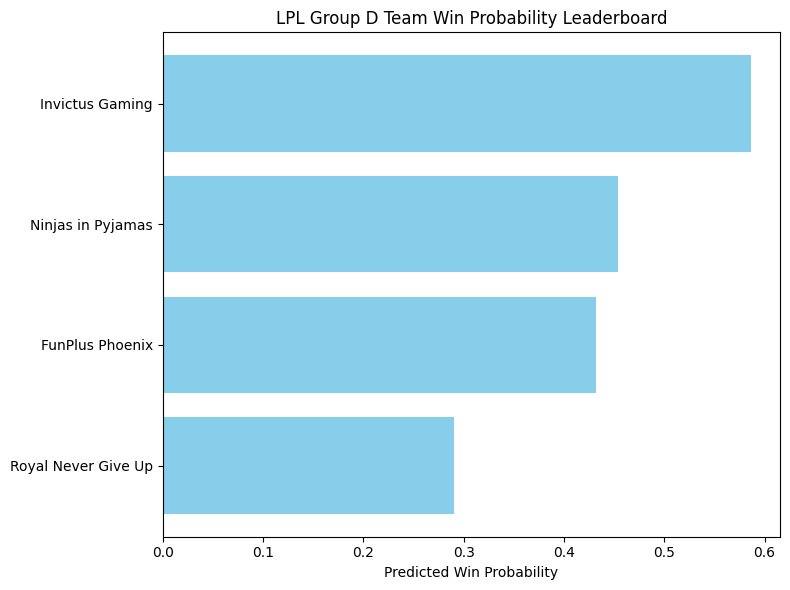

In [99]:
LPL_Group_D ={
    "FunPlus Phoenix": ["sheer", "Shad0w", "Care", "Assum", "Jwei"],
    "Invictus Gaming": ["TheShy", "Jiejie", "Rookie", "GALA", "Meiko"],
    "Ninjas in Pyjamas": ["shanji", "Aki", "Doinb", "Leave", "ppgod"],
    "Royal Never Give Up": ["Xiaoxu", "milkyway", "Tangyuan", "JiaQi", "Niket"],
}
team_probs = get_top_teams(test_df, LPL_Group_D)
standings_df =simulate_standings(team_probs, n_simulations=1000)
predicted_standings = standings_df['team'].tolist()

plot_team_probabilities(
    team_probs,
    title='LPL Group D Team Win Probability Leaderboard',
    xlabel='Predicted Win Probability',
    color='skyblue'
)

In [100]:
actual = ["Ninjas in Pyjamas", 'Invictus Gaming', "Royal Never Give Up", "FunPlus Phoenix"]
actual = {team: rank for rank, team in enumerate(actual, start=1)}
predicted_ranks = {team: rank for rank, team in enumerate(predicted_standings, start=1)}
mae = np.mean([abs(actual[team] - predicted_ranks[team]) for team in actual])
print(f'Mean Absolute Error (MAE): {mae:.2f}')

Mean Absolute Error (MAE): 1.00



🏆 Team Win Probability Leaderboard:
1. CTBC Flying Oyster: 0.6347
2. TALON: 0.5542
3. GAM Esports: 0.5277
4. MGN Vikings Esports: 0.5177
5. Team Secret Whales: 0.3930
6. DetonatioN FocusMe: 0.3084
7. Fukuoka SoftBank HAWKS gaming: 0.2328
8. Chiefs Esports Club: 0.1426

🔥 Team with highest predicted win probability: CTBC Flying Oyster (0.6347)

🏆 Predicted Team Standings (1000 simulations):
1. CTBC Flying Oyster
2. TALON
3. GAM Esports
4. MGN Vikings Esports
5. Team Secret Whales
6. DetonatioN FocusMe
7. Fukuoka SoftBank HAWKS gaming
8. Chiefs Esports Club


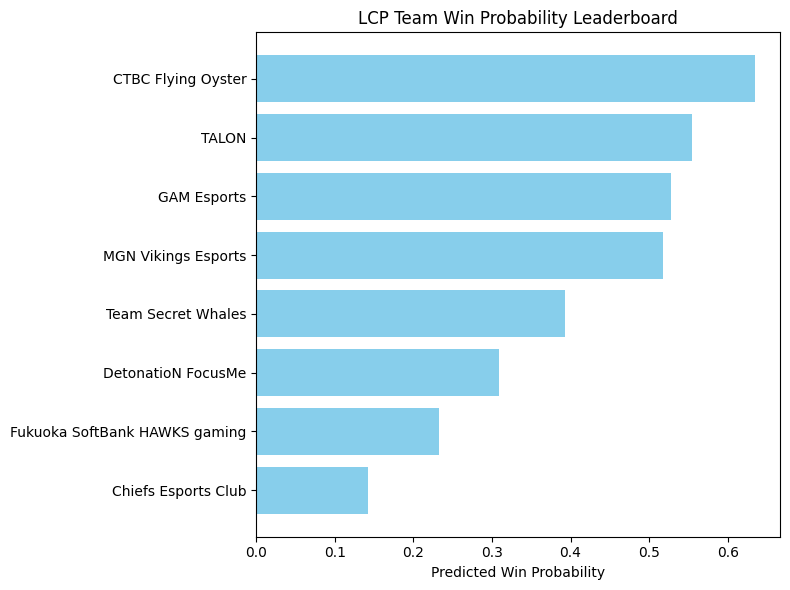

In [101]:
LCP= {
        "CTBC Flying Oyster":["Driver", "JunJia", "HongQ", "Doggo", "Kaiwing"],
        "Fukuoka SoftBank HAWKS gaming":["Evi","Courage", "FATE", "Marble", "Gaeng"],
        "GAM Esports":["Kiaya", "Levi", "Aress", "Artemis", "Elio"],
        "Chiefs Esports Club":["BioPanther", "Mir", "JimieN", "Leemas", "Luon"],
        "TALON":["Azhi","Karsa","FoFo","Betty","Woody"],
        "Team Secret Whales": ["Hiro02", "Hizto", "Dire", "Eddie", "Taki"],
        "DetonatioN FocusMe":["RayFarky", "Guwon", "Aria", "Kakkun", "Harp"],
        "MGN Vikings Esports" : ["Hasmed","Gury", "Kati", "Shogun", "SiuLoong"]
}
team_probs = get_top_teams(test_df, LCP)
standings_df =simulate_standings(team_probs, n_simulations=1000)
predicted_standings = standings_df['team'].tolist()

plot_team_probabilities(
    team_probs,
    title='LCP Team Win Probability Leaderboard',
    xlabel='Predicted Win Probability',
    color='skyblue'
)

In [102]:
actual = ['TALON', 'CTBC Flying Oyster', "MGN Vikings Esports", "Team Secret Whales",
          'GAM Esports', 'Fukuoka SoftBank HAWKS gaming', 'DetonatioN FocusMe', 'Chiefs Esports Club']
actual = {team: rank for rank, team in enumerate(actual, start=1)}
predicted_ranks = {team: rank for rank, team in enumerate(predicted_standings, start=1)}
mae = np.mean([abs(actual[team] - predicted_ranks[team]) for team in actual])
print(f'Mean Absolute Error (MAE): {mae:.2f}')

Mean Absolute Error (MAE): 1.00



🏆 Team Win Probability Leaderboard:
1. Hanwha Life: 0.7652
2. CTBC Flying Oyster: 0.6347
3. Top Esports: 0.6166
4. Team Liquid: 0.5558
5. Karmine Corp: 0.5045

🔥 Team with highest predicted win probability: Hanwha Life (0.7652)

🏆 Predicted Team Standings (1000 simulations):
1. Hanwha Life
2. CTBC Flying Oyster
3. Top Esports
4. Team Liquid
5. Karmine Corp


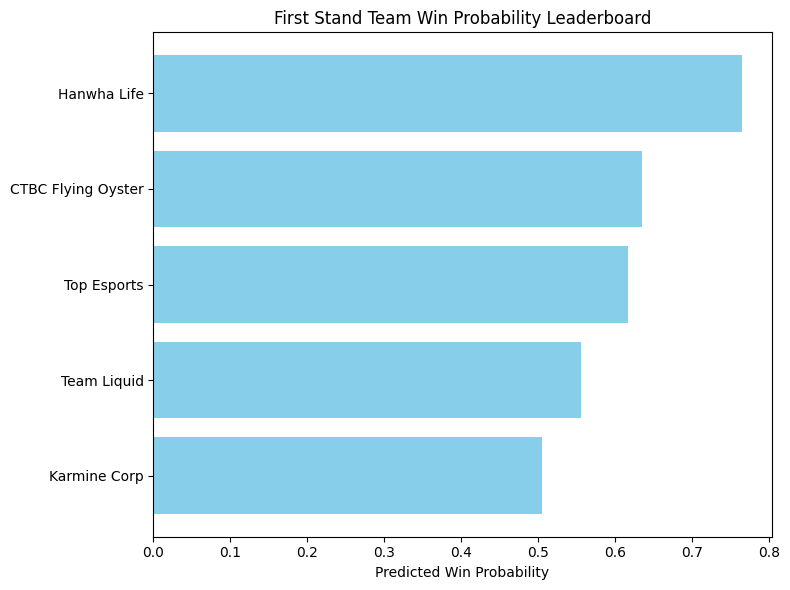

In [103]:
First_Stand = {
    "Top Esports": ["369", "Kanavi", "Creme", "JackeyLove", "Crisp"],
    "Karmine Corp": ["Canna", "Yike", "Vladi", "Caliste", "Targamas"],
    "CTBC Flying Oyster":["Driver", "JunJia", "HongQ", "Doggo", "Kaiwing"],
    "Hanwha Life": ["Zeus", "Peanut", "Zeka", "Viper", "Delight"],
    "Team Liquid":["Impact", "UmTi", "APA", "Yeon", "CoreJJ"],
}
team_probs = get_top_teams(test_df, First_Stand)
standings_df =simulate_standings(team_probs, n_simulations=1000)
predicted_standings = standings_df['team'].tolist()
plot_team_probabilities(
    team_probs,
    title='First Stand Team Win Probability Leaderboard',
    xlabel='Predicted Win Probability',
    color='skyblue'
)

In [104]:
actual = ['Hanwha Life', 'CTBC Flying Oyster', 'Top Esports', 'Team Liquid', 'Karmine Corp'
          ]
actual = {team: rank for rank, team in enumerate(actual, start=1)}
predicted_ranks = {team: rank for rank, team in enumerate(predicted_standings, start=1)}
mae = np.mean([abs(actual[team] - predicted_ranks[team]) for team in actual])
print(f'Mean Absolute Error (MAE): {mae:.2f}')

Mean Absolute Error (MAE): 0.00
